In [37]:
!wget -nc 140.114.76.113:8000/pA1.csv 
!wget -nc 140.114.76.113:8000/pA2.csv

File ‘pA1.csv’ already there; not retrieving.

File ‘pA2.csv’ already there; not retrieving.



In [38]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display
from mpl_toolkits import mplot3d
from matplotlib import cm 

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
Learning_rate = 6e-2
batch_size = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# Dataloader for A1, A2
class Data:
    def __init__(self, csv_path, net):
        self.csv_path = csv_path
        self.net = net
        self.Read_file()
        
    def Read_file(self):
        data = pd.read_csv(self.csv_path)
        x, y = data.values.T[0], data.values.T[1]
        append = np.ones(len(x), dtype = float)

        if self.net == 'A1':
            x = np.vstack([x, append]).T
        else:
            x = np.vstack([x**2, x, append]).T
        self.x, self.y = torch.from_numpy(x).float(), torch.from_numpy(y).float()

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x.to(device), y.to(device)


In [0]:
# NetA1
# Simulate y = ax + b 
class NetA1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2,1, bias=False)
        
    def forward(self, x):
        return self.linear(x)

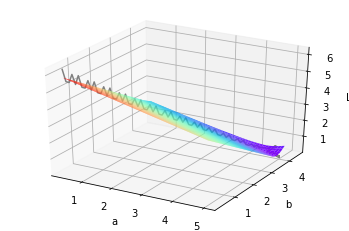

In [41]:
def Do_A1():
    A1 = NetA1().to(device)
    A1data = Data('pA1.csv', 'A1')
    A1loader = DataLoader(A1data, batch_size = batch_size)
    criterion = nn.L1Loss()

    optimizer = torch.optim.Adam(A1.parameters(), lr = Learning_rate)
    record = {'loss':[], 'a':[], 'b':[]}
    for epoch in range(100):
        for x, y in iter(A1loader):
            optimizer.zero_grad()
            # pred 
            pred = A1(x)
            loss = criterion(pred, y.view(batch_size, -1))

            loss.backward()
            optimizer.step()

            a, b = tuple(A1.linear.weight.cpu().detach().numpy().reshape(-1))#list(A1.parameters())[0].cpu().data.numpy()[0]
            

            record['loss'].append(loss)
            record['a'].append(a)
            record['b'].append(b)

    return record['a'], record['b'], record['loss']


def Plot_Surface():
    a, b, loss = Do_A1()

    a_max = max(a)
    a_min = min(a)
    
    b_max = max(b)
    b_min = min(b)

    A = np.arange(a_min, a_max, 0.1)
    B = np.arange(b_min, b_max, 0.1)
    A, B = np.meshgrid(A, B)
    
    data = pd.read_csv('pA1.csv')
    x, y = data.values.T[0], data.values.T[1]
    Z = []
    # Z is average error surface
    for bj in B.T[0]:
        tmp = []
        for ai in A[0]:
            error = np.mean(np.abs(y - (ai*x+bj)))
            tmp.append(error)
        Z.append(tmp)
    Z = np.array(Z)


    
    fig = plt.figure()
    gradient = plt.axes(projection='3d')

    gradient.plot_surface(A, B, Z, cmap = cm.rainbow)
    gradient.set_xlabel('a')
    gradient.set_ylabel('b')
    gradient.set_zlabel('L')

    zline = np.array(loss)
    xline = np.array(a)
    yline = np.array(b)
    gradient.plot3D(xline, yline, zline, 'gray')
    plt.show()
    %matplotlib inline


def Plot_Line():
    a, b, loss = Do_A1()
    data = pd.read_csv('pA1.csv')
    x, y = data.values.T[0], data.values.T[1]
    r = np.arange(0,1, 0.1)
    pred = a[-1]*r + b[-1] 
    plt.plot(x, y, 'o')
    plt.plot(r, pred, 'r')
    plt.close()
    
Plot_Surface()
#Plot_Line()


In [0]:
# NetA2
# Simulate y = ax**2+ bx + c (a = w0, b = w1, c = w2)
class NetA2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3,1, bias=False)
        
    def forward(self, x):
        return self.linear(x)

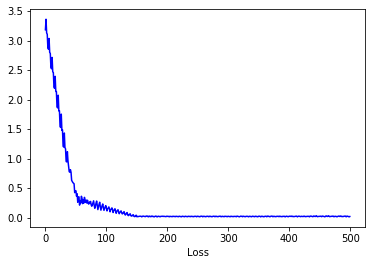

In [43]:
def Do_A2():
    A2 = NetA2().to(device)
    A2data = Data('pA2.csv', 'A2')
    A2loader = DataLoader(A2data, batch_size = batch_size)
    criterion = nn.L1Loss()

    optimizer = torch.optim.Adam(A2.parameters(), lr = Learning_rate)
    record = {'loss':[], 'a':[], 'b':[], 'c':[]}
    for epoch in range(100):
        for x, y in iter(A2loader):
            optimizer.zero_grad()
            # pred 
            pred = A2(x)
            loss = criterion(pred, y.view(batch_size, -1))

            loss.backward()
            optimizer.step()

            a, b, c = tuple(A2.linear.weight.cpu().detach().numpy().reshape(-1))#list(A2.parameters())[0].cpu().data.numpy()[0]
            

            record['loss'].append(loss)
            record['a'].append(a)
            record['b'].append(b)
            record['c'].append(c)

    return record['a'], record['b'], record['c'], record['loss']

def Plot_Loss():
    a, b, c, loss = Do_A2()
    r = np.arange(500)
    plt.plot(r, loss, color = 'b')
    plt.xlabel('iterations')
    plt.xlabel('Loss')
    plt.show()
    %matplotlib inline




def Plot_Line():
    a, b, c, loss = Do_A2()
    data = pd.read_csv('pA2.csv')
    x, y = data.values.T[0], data.values.T[1]
    r = np.arange(-0.5,0.6, 0.1)
    pred = a[-1]*r*r + b[-1]*r + c[-1] 
    plt.plot(x, y, 'o')
    plt.plot(r, pred, 'r')
    plt.show()


Plot_Loss()
#Plot_Line()
